<a href="https://colab.research.google.com/github/JulioCastillo1/TP1-Datos/blob/master/TP1-Datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%pylab inline

url='https://raw.githubusercontent.com/JulioCastillo1/TP1-Datos/master/train.csv'
tweets = pd.read_csv(url)
   

Populating the interactive namespace from numpy and matplotlib


Creo un gráfico del porcentaje de veracidad de tweets para cada keyword

In [40]:

tweets['keyword'] = tweets['keyword'].astype('category')
#tweets['keyword'].value_counts()

truth_percentage_by_keyword = tweets.groupby('keyword')['target'].agg('mean')\
    .to_frame()\
    .reset_index()\
    .sort_values(by='target', ascending=False)\
    .round({'target': 4})
truth_percentage_by_keyword.columns = ['keyword', 'percentage']
truth_percentage_by_keyword['percentage'] = truth_percentage_by_keyword['percentage'] * 100
truth_percentage_by_keyword.head()

#truth_percentage_by_keyword.info()




,keyword,percentage
62,debris,100.00
219,wreckage,100.00
70,derailment,100.00
153,outbreak,97.50
152,oil%20spill,97.37


In [0]:
truth_percentage_by_keyword.plot(kind='bar', figsize=(16,8), rot=0, title='Veracidad de tweets en función del tamaño', color='green');
ax = plt.gca();
ax.set_xlabel('Tamaño de los tweets en caracteres')
ax.set_ylabel('Porcentaje de tweets verdaderos')



In [0]:
tweets['longitud'] = tweets['text'].str.len()
tweets_description = tweets['longitud'].describe()
tweets_description = tweets_description.to_frame()
tweets_description.rename(index={'mean':'promedio', 'min':'mínimo', 'max':'máximo'}, inplace=True)
tweets_description.drop(['count', 'std', '25%', '50%', '75%'], inplace=True)
tweets_description['longitud'] = tweets_description['longitud'].astype(int)
tweets_description

,longitud
promedio,101
mínimo,7
máximo,157


In [0]:
bins = pd.cut(tweets['longitud'], bins=[0, 20, 40, 60, 80, 100, 120, 140, 160, 180])
tweets['bin'] = bins
tweets

,id,keyword,location,text,target,longitud,bin
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,"(60, 80]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,"(20, 40]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,"(120, 140]"
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,"(60, 80]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,"(80, 100]"
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,"(80, 100]"
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,"(120, 140]"
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,"(60, 80]"
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137,"(120, 140]"


In [0]:
tweets_percentage = tweets.groupby('bin').agg({'target':'mean'})
tweets_percentage['target'] = round(tweets_percentage['target'] * 100, 2);
tweets_percentage.rename(columns={'target':'porcentaje'}, inplace=True)

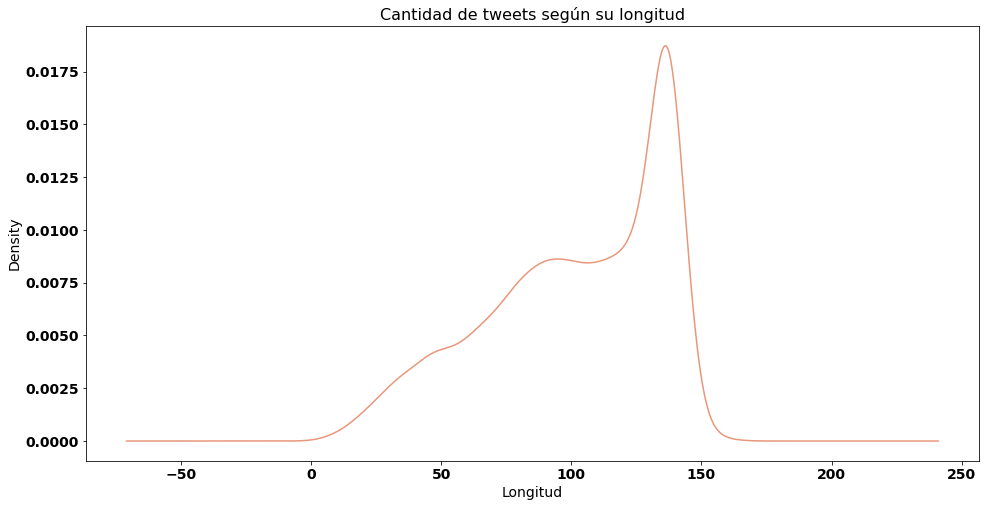

In [0]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.weight'] = 'bold'

fig = plt.figure()
ax = fig.add_subplot(111)

plt.title('Cantidad de tweets según su longitud', fontsize=16)
ax.set_xlabel('Longitud')
tweets['longitud'].plot.kde(color='darksalmon', figsize=(16, 8))

plt.show()

Text(0, 0.5, 'Cantidad de caracteres')

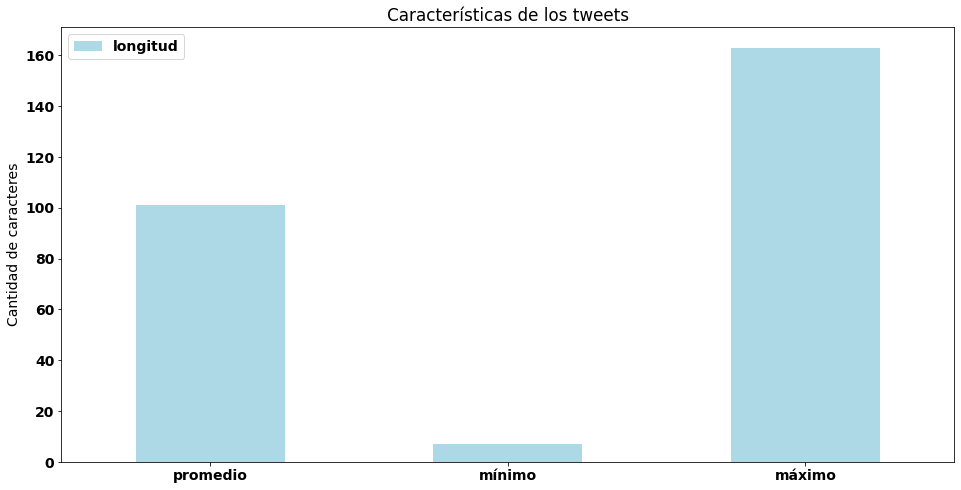

In [0]:
tweets_description.plot(kind='bar', figsize=(16,8), rot=0, title='Características de los tweets', color='lightblue');
ax = plt.gca();
ax.set_ylabel('Cantidad de caracteres')

Text(0, 0.5, 'Porcentaje de tweets verdaderos')

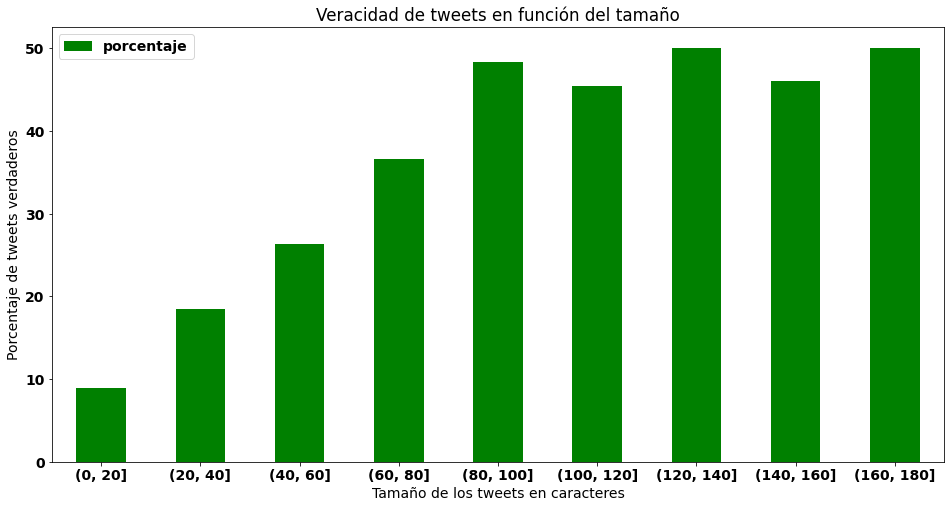

In [0]:
tweets_percentage.plot(kind='bar', figsize=(16,8), rot=0, title='Veracidad de tweets en función del tamaño', color='green');
ax = plt.gca();
ax.set_xlabel('Tamaño de los tweets en caracteres')
ax.set_ylabel('Porcentaje de tweets verdaderos')